<a href="https://www.kaggle.com/code/maithanhlm/intel-image-classification-dataset?scriptVersionId=139502857" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


14034
3000
Found 14034 files belonging to 6 classes.
Found 14034 files belonging to 6 classes.
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 150, 150, 30  2280        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (

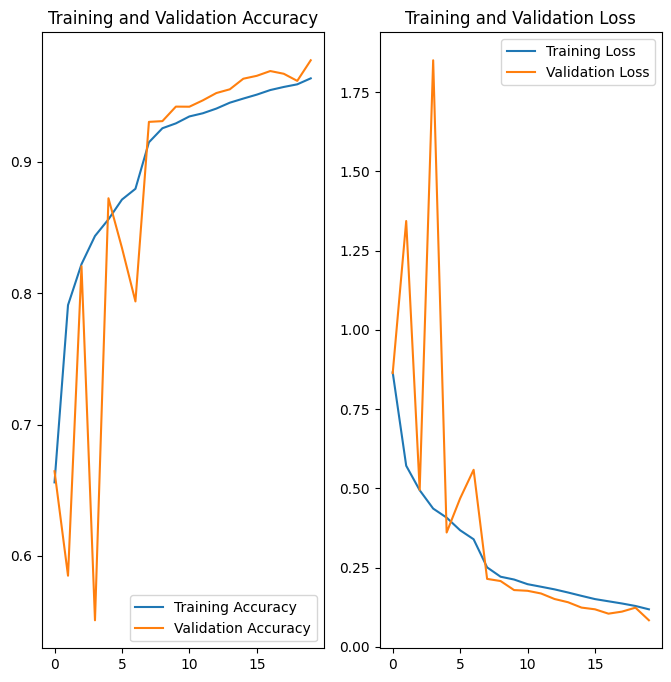

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pathlib
from keras.utils.vis_utils import plot_model
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Add, Flatten, Dropout, ReLU
from keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2

data_dir_01 = pathlib.Path('/kaggle/input/final-project-ai-datasets/final_project_dataset/training_set')
image_count_01 = len(list(data_dir_01.glob('*/*.jpg')))
print(image_count_01)

data_dir_02 = pathlib.Path('/kaggle/input/final-project-ai-datasets/final_project_dataset/test_set')
image_count_02 = len(list(data_dir_02.glob('*/*.jpg')))
print(image_count_02)


batch_size = 64
img_height = 150
img_width = 150

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_01,
    validation_split=0,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_01,
    validation_split=0.0,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)




class_names = train_ds.class_names
print(class_names)

input_shape = (img_height, img_width, 3)
num_classes = len(class_names)


# create model
def resnet_block(inputs, filters, strides =1):
    shortcut = inputs
    x = Conv2D(filters, kernel_size=3, padding='same', strides=strides)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
   
    if strides > 1:
        shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(inputs)
        
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x


def model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(30, kernel_size=5, strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    
    x = resnet_block(x, filters=15, strides=2)
    x = resnet_block(x, filters=15)
    x = resnet_block(x, filters=15)
    
  

    x = resnet_block(x, filters=30, strides =2 )
    x = resnet_block(x, filters=30)
    x = resnet_block(x, filters=30)
    

    x = resnet_block(x, filters=60, strides =2 )
    x = resnet_block(x, filters=60)
    x = resnet_block(x, filters=60)
    
    
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
                                    
                                    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model



model = model(input_shape, num_classes)
model.summary()

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
model.compile(optimizer='Adamax',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])



learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, verbose=1, mode='auto')


# Train the model
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,shuffle=True,callbacks=learning_rate_reduction)

#Plotting
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

